# Pivot Tables
This notebook was adapted from one of the notebooks of [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) by Jake VanderPlas.

-----

We have seen how the ``GroupBy`` abstraction lets us explore relationships within a dataset.
A *pivot table* is a similar operation that is commonly seen in spreadsheets and other programs that operate on tabular data.
The pivot table takes simple column-wise data as input, and groups the entries into a two-dimensional table that provides a multidimensional summarization of the data.
The difference between pivot tables and ``GroupBy`` can sometimes cause confusion; it helps me to think of pivot tables as essentially a *multidimensional* version of ``GroupBy`` aggregation.
That is, you split-apply-combine, but both the split and the combine happen across not a one-dimensional index, but across a two-dimensional grid.

## Motivating Pivot Tables

For the examples in this section, we'll use the database of passengers on the *Titanic*, available through the Seaborn library (see [Visualization With Seaborn](04.14-Visualization-With-Seaborn.ipynb)):

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
titanic = sns.load_dataset('titanic')
titanic.sample(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
319,1,1,female,40.0,1,1,134.500,C,First,woman,False,E,Cherbourg,yes,False
636,0,3,male,32.0,0,0,7.925,S,Third,man,True,NaN,Southampton,no,True
249,0,2,male,54.0,1,0,26.000,S,Second,man,True,NaN,Southampton,no,False
747,1,2,female,30.0,0,0,13.000,S,Second,woman,False,NaN,Southampton,yes,True
279,1,3,female,35.0,1,1,20.250,S,Third,woman,False,NaN,Southampton,yes,False


This contains a wealth of information on each passenger of that ill-fated voyage, including gender, age, class, fare paid, and much more.

## Pivot Tables by Hand

To start learning more about this data, we might begin by grouping according to gender, survival status, or some combination thereof.
If you have read the previous section, you might be tempted to apply a ``GroupBy`` operation–for example, let's look at survival rate by gender:

In [3]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


This immediately gives us some insight: overall, three of every four females on board survived, while only one in five males survived!

This is useful, but we might like to go one step deeper and look at survival by both sex and, say, class.
Using the vocabulary of ``GroupBy``, we might proceed using something like this:
we *group by* class and gender, *select* survival, *apply* a mean aggregate, *combine* the resulting groups, and then *unstack* the hierarchical index to reveal the hidden multidimensionality. In code:

In [4]:
# titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()
titanic.groupby(['sex', 'class'])['survived'].mean().unstack()

<ipython-input-4-0073ec07ceed>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  titanic.groupby(['sex', 'class'])['survived'].mean().unstack()


class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This gives us a better idea of how both gender and class affected survival, but the code is starting to look a bit garbled.
While each step of this pipeline makes sense in light of the tools we've previously discussed, the long string of code is not particularly easy to read or use.
This two-dimensional ``GroupBy`` is common enough that Pandas includes a convenience routine, ``pivot_table``, which succinctly handles this type of multi-dimensional aggregation.

## Pivot Table Syntax

Here is the equivalent to the preceding operation using the ``pivot_table`` method of ``DataFrame``s:

In [5]:
titanic.pivot_table('survived', index='sex', columns='class')

<ipython-input-5-5d144336edf1>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  titanic.pivot_table('survived', index='sex', columns='class')


class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


Or simply ...

In [6]:
titanic.pivot_table('survived', 'sex', 'class')

<ipython-input-6-12645f54fe1f>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  titanic.pivot_table('survived', 'sex', 'class')


class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This is eminently more readable than the ``groupby`` approach, and produces the same result.
As you might expect of an early 20th-century transatlantic cruise, the survival gradient favors both women and higher classes.
First-class women survived with near certainty (hi, Rose!), while only one in ten third-class men survived (sorry, Jack!).

### Multi-level pivot tables

Just as in the ``GroupBy``, the grouping in pivot tables can be specified with multiple levels, and via a number of options.
For example, we might be interested in looking at age as a third dimension.
We'll bin the age using the ``pd.cut`` function:

In [7]:
titanic.head(7)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True


In [8]:
age = pd.cut(titanic['age'], [0, 18, 30, 50, 80])
age.head(7)

,age
0,"(18.0, 30.0]"
1,"(30.0, 50.0]"
2,"(18.0, 30.0]"
3,"(30.0, 50.0]"
4,"(30.0, 50.0]"
5,NaN
6,"(50.0, 80.0]"


We can apply the same strategy when working with the columns as well; let's add info on the fare paid using ``pd.qcut`` to automatically compute quantiles:

In [9]:
titanic.pivot_table('survived', index = ['sex', age], columns = 'class')

<ipython-input-9-5b206a849d33>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  titanic.pivot_table('survived', index = ['sex', age], columns = 'class')


class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 30]  0.958333  0.900000  0.500000
       (30, 50]  0.972973  0.925926  0.272727
       (50, 80]  1.000000  0.666667  1.000000
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 30]  0.428571  0.027027  0.147541
       (30, 50]  0.448980  0.114286  0.126761
       (50, 80]  0.192308  0.083333  0.000000

In [10]:
fare = pd.qcut(titanic['fare'], 2)
fare.head()

,fare
0,"(-0.001, 14.454]"
1,"(14.454, 512.329]"
2,"(-0.001, 14.454]"
3,"(14.454, 512.329]"
4,"(-0.001, 14.454]"


In [11]:
titanic.pivot_table('survived', index = ['sex', age], columns = [fare, 'class'])

<ipython-input-11-e9a751084422>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  titanic.pivot_table('survived', index = ['sex', age], columns = [fare, 'class'])


fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 30]              NaN  0.916667  0.500000          0.958333   
       (30, 50]              NaN  0.916667  0.142857          0.972973   
       (50, 80]              NaN  0.000000  1.000000          1.000000   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 30]              NaN  0.040000  0.138889          0.428571   
       (30, 50]              0.0  0.176471  0.118644          0.488889   
       (50, 80]              NaN  0.111111  0.000000          0.192308   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 30]  0.888889  0.500000  
       (30, 50]  0.933333  0.333333  
       (50, 80]  1.000000       NaN  
male   (0, 18]   0.818182  0.178571  
       (18, 30]  0.000000  0.214286  
       (30, 50]  0.055556  0.166667  
       (50, 80]  0.000000       NaN

The result is a four-dimensional aggregation with hierarchical indices (see [Hierarchical Indexing](03.05-Hierarchical-Indexing.ipynb)), shown in a grid demonstrating the relationship between the values.

### Additional pivot table options

The full call signature of the ``pivot_table`` method of ``DataFrame``s is as follows:

```python
# call signature as of Pandas 0.18
DataFrame.pivot_table(data, values=None, index=None, columns=None,
                      aggfunc='mean', fill_value=None, margins=False,
                      dropna=True, margins_name='All')
```

We've already seen examples of the first three arguments; here we'll take a quick look at the remaining ones.
Two of the options, ``fill_value`` and ``dropna``, have to do with missing data and are fairly straightforward; we will not show examples of them here.

The ``aggfunc`` keyword controls what type of aggregation is applied, which is a mean by default.
As in the GroupBy, the aggregation specification can be a string representing one of several common choices (e.g., ``'sum'``, ``'mean'``, ``'count'``, ``'min'``, ``'max'``, etc.) or a function that implements an aggregation (e.g., ``np.sum()``, ``min()``, ``sum()``, etc.).
Additionally, it can be specified as a dictionary mapping a column to any of the above desired options:

In [12]:
titanic.pivot_table(index='sex', columns='class',
                    aggfunc={'survived':sum, 'fare':'mean'})

<ipython-input-12-02c18684cfac>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  titanic.pivot_table(index='sex', columns='class',
<ipython-input-12-02c18684cfac>:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  titanic.pivot_table(index='sex', columns='class',


fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

Notice also here that we've omitted the ``values`` keyword; when specifying a mapping for ``aggfunc``, this is determined automatically.

At times it's useful to compute totals along each grouping.
This can be done via the ``margins`` keyword:

In [13]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)

<ipython-input-13-0ab51900a79c>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  titanic.pivot_table('survived', index='sex', columns='class', margins=True)


class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


Here this automatically gives us information about the class-agnostic survival rate by gender, the gender-agnostic survival rate by class, and the overall survival rate of 38%.
The margin label can be specified with the ``margins_name`` keyword, which defaults to ``"All"``.

## Example: Birthrate Data

As a more interesting example, let's take a look at the freely available data on births in the United States, provided by the Centers for Disease Control (CDC).
This data can be found at https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv
(this dataset has been analyzed rather extensively by Andrew Gelman and his group; see, for example, [this blog post](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/)):

In [14]:
import pandas as pd
births = pd.read_csv('https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv')
births.shape

(15547, 5)

Taking a look at the data, we see that it's relatively simple–it contains the number of births grouped by date and gender:

In [15]:
births.sample(5)

,year,month,day,gender,births
6604,1977,8,24.0,F,4983
5244,1975,11,8.0,M,4013
14827,1988,9,3.0,M,5091
4224,1974,7,8.0,M,4957
10552,1982,11,26.0,M,4759


We can start to understand this data a bit more by using a pivot table.
Let's add a decade column, and take a look at male and female births as a function of decade:

In [16]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


We immediately see that male births outnumber female births in every decade.
To see this trend a bit more clearly, we can use the built-in plotting tools in Pandas to visualize the total number of births by year (see [Introduction to Matplotlib](04.00-Introduction-To-Matplotlib.ipynb) for a discussion of plotting with Matplotlib):

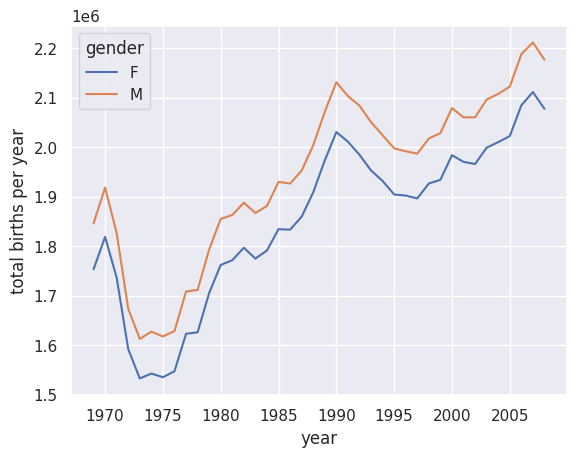

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()  # use Seaborn styles
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year');

With a simple pivot table and ``plot()`` method, we can immediately see the annual trend in births by gender. By eye, it appears that over the past 50 years male births have outnumbered female births by around 5%.